In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

from tqdm import tqdm

import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

import numpy as np
import matplotlib.pyplot as plt
import cv2

C:\Users\matth\Programming\Research\2025\CVPR\SaRaCVPR\sam2\sam2\modeling\sam\transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [2]:
CONFIG_PATH = "./sam2/sam2/configs/sam2.1/"
YAML_CONFIG = "sam2.1_hiera_b+.yaml"
# YAML_CONFIG = "sam2.1_hiera_t.yaml"

FULL_PATH = os.path.join(CONFIG_PATH, YAML_CONFIG)

TEST_IMG_PATH = "./test_images/"
images = os.listdir(TEST_IMG_PATH)
images = [f"{TEST_IMG_PATH}{img}" for img in images]

initialize(version_base=None, config_path=CONFIG_PATH, job_name="test_app")
cfg = compose(config_name=YAML_CONFIG, overrides=[])

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [3]:
checkpoint = "./sam2/checkpoints/sam2.1_hiera_base_plus.pt"
# checkpoint = "./sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = YAML_CONFIG
# predictor = SAM2ImagePredictor(build_sam2(YAML_CONFIG, checkpoint))
sam2 = build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    # points_per_side=16,
    # points_per_batch=16,
    pred_iou_thresh=0.9,
    # stability_score_thresh=0.92,
    # stability_score_offset=0.7,
    # crop_n_layers=1,
    # box_nms_thresh=0.7,
    # crop_n_points_downscale_factor=2,
    # min_mask_region_area=200.0,
    # use_m2m=True,
)

# mask_generator = SAM2ImagePredictor(
#     sam_model=sam2,
#     min_mask_region_area=2000.0,
# )

In [4]:
images

['./test_images/cars.jpg', './test_images/dog.jpg', './test_images/dog2.jpg']

In [5]:
test_image = np.array(Image.open(images[1]).convert("RGB"))

# Batch of test images
# test_images = [np.array(Image.open(img).convert("RGB")) for img in images]

masks = mask_generator.generate(test_image)

C:\Users\matth\Programming\Research\2025\CVPR\SaRaCVPR\sam2\sam2\modeling\backbones\hieradet.py:70: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(


In [6]:
class ASSRDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_name = os.path.join(self.mask_dir, self.image_filenames[idx].replace('.jpg', '.png'))  # adjust if needed

        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('L')  # Assuming masks are grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [8]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from tqdm import tqdm  # Import TQDM

def calculate_mae(pred, gt):
    return np.mean(np.abs(pred - gt))

# Calculate SOR using Spearman's Rank Correlation
def calculate_sor(pred, gt):
    # Find object blobs using cv2
    _, pred_objects = cv2.connectedComponents(pred.astype(np.uint8))

    # Extract all unique pixel values in gt
    unique_gt = np.unique(gt)

    # Remove 0
    unique_gt = unique_gt[unique_gt != 0]

    # Create a mapping from pixel value to object number. Rank them max to 1, with 1 being highest rank
    gt_objects = np.zeros_like(gt)
    rank = len(unique_gt)
    for i, val in enumerate(unique_gt):
        gt_objects[gt == val] = rank
        rank -= 1

    gt_ranks = []

    # Mapping from object number to rank
    for i in range(1, int(np.max(gt_objects)) + 1):
        gt_ranks.append(np.mean(gt_objects == i))

    # Get indices which would sort the array
    sorted_gt_ranks = np.argsort(gt_ranks) + 1

    # Find 1:1 object matches with > 0.5 IoU
    matches = {}

    for i in range(1, int(np.max(pred_objects)) + 1):
        pred_mask = pred_objects == i
        pred_mask = pred_mask.astype(np.uint8)

        for j in range(1, np.max(gt_objects) + 1):
            gt_mask = gt_objects == j
            gt_mask = gt_mask.astype(np.uint8)

            intersection = np.sum(pred_mask & gt_mask)
            union = np.sum(pred_mask | gt_mask)

            iou = intersection / union

            if iou > 0.1:
                matches[i] = {}
                matches[i]["iou"] = iou
                matches[i]["pred_saliency"] = np.mean(pred_objects == i)
                # Get GT rank from match in sorted_gt_ranks
                matches[i]["gt_rank"] = sorted_gt_ranks[j - 1]



    # Sort matches based on avg saliency, then separate into integers
    sorted_matches = sorted(matches.items(), key=lambda x: x[1]["pred_saliency"], reverse=True)
    rank = 1

    for i, match in enumerate(sorted_matches):
        matches[match[0]]["pred_rank"] = rank
        rank += 1

    pred_ranks_final = []
    gt_ranks_final = []

    # print(f'GT ranks: {sorted_gt_ranks}')
    for k, v in matches.items():
        # print(f'{k} -> {v}')
        pred_rank = v["pred_rank"]
        gt_rank = v["gt_rank"]

        pred_ranks_final.append(pred_rank)
        gt_ranks_final.append(gt_rank)

    if len(pred_ranks_final) == 0:
        return None
    
    sprc = spearmanr(pred_ranks_final, gt_ranks_final).correlation

    # Normalise to range [0, 1]
    sprc = (sprc + 1) / 2

    print(pred_ranks_final)
    print(gt_ranks_final)
    print(f'SPRC: {sprc}')

    return sprc

In [9]:
import deepgaze_pytorch
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp

# Initialize the model
saliency_model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(device)

c:\Users\matth\anaconda3\envs\sara\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\matth\anaconda3\envs\sara\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\matth\anaconda3\envs\sara\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\matth\anaconda3\envs\sara\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg

In [10]:
class SaliencyRankPredictor():
    def __init__(self, saliency_model, sam2_model, depth_model=None):
        self.saliency_model = saliency_model
        self.sam2_model = sam2_model
        self.depth_model = depth_model

    def predict(self, image):
        print('Generating saliency map')
        saliency_map = self.generate_saliency(image)

        print('Generating masks')
        masks = self.sam2_model.generate(image)

        # depth_map = self.depth_model(image)

        print('Ranking segments')
        segment_ranks = self.rank_segments(saliency_map, masks)

        print('Generating grayscale image')
        grayscale_image = self.generate_grayscale(segment_ranks, image)

        return saliency_map, masks, segment_ranks, grayscale_image

    def generate_saliency(self, image):
        original_size = image.shape[:2]
        image = cv2.resize(image, (256, 256))

        centerbias_template = np.zeros((1024, 1024))
        centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
        centerbias -= logsumexp(centerbias)

        with torch.no_grad():
            image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(device)
            centerbias_tensor = torch.tensor([centerbias]).to(device)
            log_density_prediction = self.saliency_model(image_tensor, centerbias_tensor)

        del image_tensor, centerbias_tensor
        torch.cuda.empty_cache()

        saliency_map = cv2.resize(log_density_prediction.detach().cpu().numpy()[0, 0], (original_size[1], original_size[0]))
        saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))
        return saliency_map

    def rank_segments(self, saliency_map, masks):
        segment_ranks = {}

        for i, mask in enumerate(masks):
            mask = mask['segmentation']
            object_saliency = saliency_map[mask == 1]
            saliency_score = np.sum(object_saliency)
            segment_ranks[i] = {}
            segment_ranks[i]['saliency'] = saliency_score
            segment_ranks[i]['mask'] = mask
            segment_ranks[i]['size'] = np.sum(mask == 1)

        # Sort the segments by rank
        sorted_segment_ranks = sorted(segment_ranks.items(), key=lambda x: x[1]['saliency'], reverse=True) # Descending order

        return sorted_segment_ranks
    
    def generate_grayscale(self, segment_ranks, image):
        grayscale_image = np.zeros((image.shape[0], image.shape[1]))
        unique_colours = np.linspace(0.5, 1, len(segment_ranks))
        print(unique_colours)
        unique_colours = list(reversed(unique_colours))

        # Assign colours to segment_ranks
        for i, segment in enumerate(segment_ranks):
            segment[1]['colour'] = unique_colours[i]

        # Sort by size
        segment_ranks = sorted(segment_ranks, key=lambda x: x[1]['size'], reverse=False) # Descending order

        for segment in segment_ranks:
            mask = segment[1]['mask']
            mask[grayscale_image > 0] = 0
            colour = segment[1]['colour']
            grayscale_image += mask * colour

        return grayscale_image


In [79]:
# test_images = [np.array(Image.open(img).convert("RGB")) for img in images]
predictor = SaliencyRankPredictor(saliency_model, mask_generator)

In [13]:
test_dataset = ASSRDataset(image_dir='./ASSR/images/test', mask_dir='./ASSR/gt/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1)

In [78]:
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    # points_per_side=8,
    # points_per_batch=32,
    # pred_iou_thresh=0.8,
    # stability_score_thresh=0.95,
    # stability_score_offset=0.7,
    # crop_n_layers=1,
    # # box_nms_thresh=0.1,
    # crop_n_points_downscale_factor=2,
    # # min_mask_region_area=2000.0,
    # # use_m2m=True,
)

  0%|          | 0/2418 [00:00<?, ?it/s]

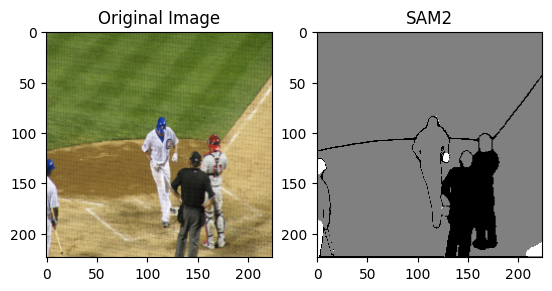

  0%|          | 1/2418 [00:04<3:02:08,  4.52s/it]

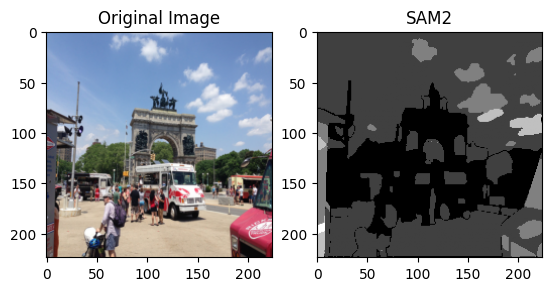

  0%|          | 2/2418 [00:09<3:04:42,  4.59s/it]

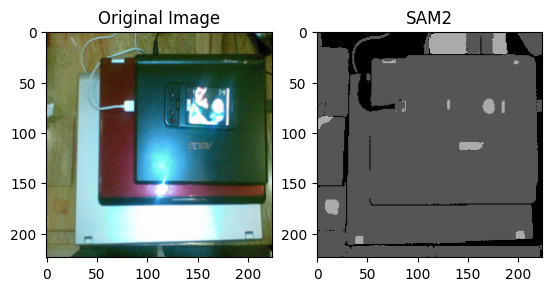

  0%|          | 3/2418 [00:13<2:56:17,  4.38s/it]

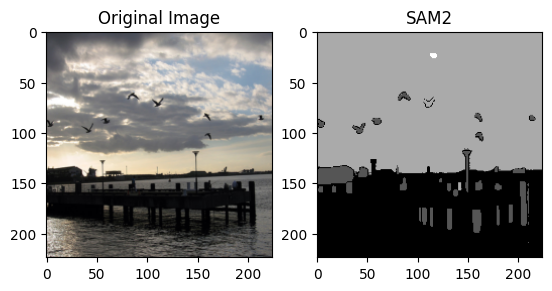

  0%|          | 4/2418 [00:17<2:59:58,  4.47s/it]

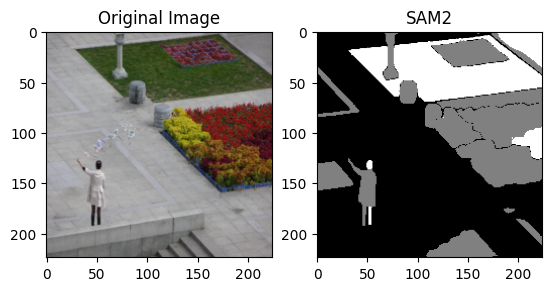

  0%|          | 5/2418 [00:22<2:57:26,  4.41s/it]

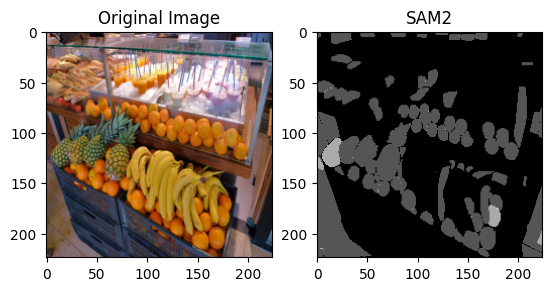

  0%|          | 6/2418 [00:29<3:17:37,  4.92s/it]


KeyboardInterrupt: 

In [80]:
for image, mask in tqdm(test_loader):
    image = image.squeeze(0).permute(1, 2, 0).numpy()

    masks = mask_generator.generate(image)

    pred_mask = np.zeros((image.shape[0], image.shape[1]))
    for i, mask in enumerate(masks):
        pred_mask += mask['segmentation']

    plt.figure()
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Original Image')
    plt.subplot(122)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('SAM2')

    plt.show()

  0%|          | 0/2418 [00:00<?, ?it/s]

Generating saliency map
Generating masks
Ranking segments
Generating grayscale image
[0.5        0.54545455 0.59090909 0.63636364 0.68181818 0.72727273
 0.77272727 0.81818182 0.86363636 0.90909091 0.95454545 1.        ]


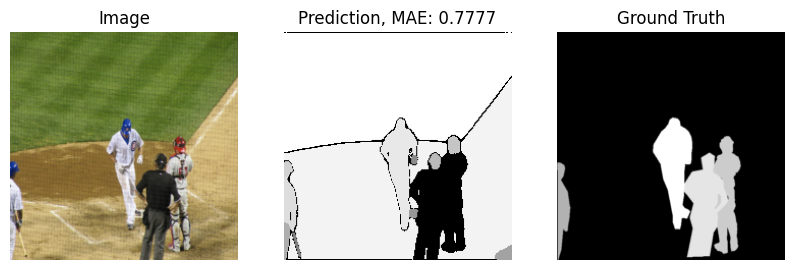

  0%|          | 1/2418 [00:06<4:28:26,  6.66s/it]

Generating saliency map
Generating masks
Ranking segments
Generating grayscale image
[0.5        0.50909091 0.51818182 0.52727273 0.53636364 0.54545455
 0.55454545 0.56363636 0.57272727 0.58181818 0.59090909 0.6
 0.60909091 0.61818182 0.62727273 0.63636364 0.64545455 0.65454545
 0.66363636 0.67272727 0.68181818 0.69090909 0.7        0.70909091
 0.71818182 0.72727273 0.73636364 0.74545455 0.75454545 0.76363636
 0.77272727 0.78181818 0.79090909 0.8        0.80909091 0.81818182
 0.82727273 0.83636364 0.84545455 0.85454545 0.86363636 0.87272727
 0.88181818 0.89090909 0.9        0.90909091 0.91818182 0.92727273
 0.93636364 0.94545455 0.95454545 0.96363636 0.97272727 0.98181818
 0.99090909 1.        ]


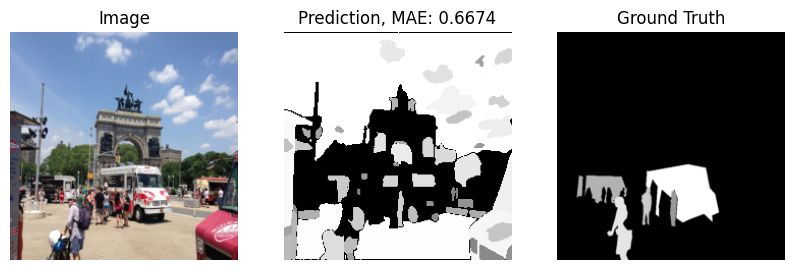

  0%|          | 2/2418 [00:13<4:32:55,  6.78s/it]

Generating saliency map
Generating masks
Ranking segments
Generating grayscale image
[0.5        0.51515152 0.53030303 0.54545455 0.56060606 0.57575758
 0.59090909 0.60606061 0.62121212 0.63636364 0.65151515 0.66666667
 0.68181818 0.6969697  0.71212121 0.72727273 0.74242424 0.75757576
 0.77272727 0.78787879 0.8030303  0.81818182 0.83333333 0.84848485
 0.86363636 0.87878788 0.89393939 0.90909091 0.92424242 0.93939394
 0.95454545 0.96969697 0.98484848 1.        ]


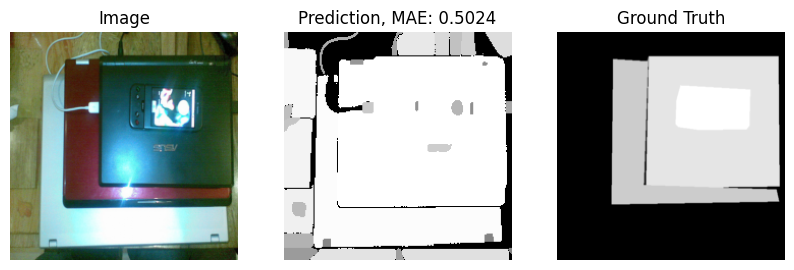

  0%|          | 3/2418 [00:19<4:25:59,  6.61s/it]

Generating saliency map
Generating masks
Ranking segments
Generating grayscale image
[0.5        0.51388889 0.52777778 0.54166667 0.55555556 0.56944444
 0.58333333 0.59722222 0.61111111 0.625      0.63888889 0.65277778
 0.66666667 0.68055556 0.69444444 0.70833333 0.72222222 0.73611111
 0.75       0.76388889 0.77777778 0.79166667 0.80555556 0.81944444
 0.83333333 0.84722222 0.86111111 0.875      0.88888889 0.90277778
 0.91666667 0.93055556 0.94444444 0.95833333 0.97222222 0.98611111
 1.        ]


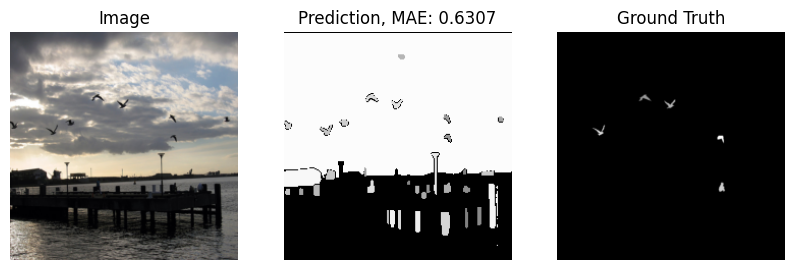

  0%|          | 4/2418 [00:26<4:29:05,  6.69s/it]

Generating saliency map
Generating masks
Ranking segments
Generating grayscale image
[0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]


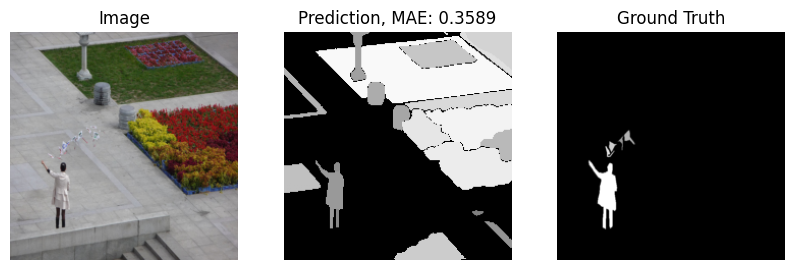

  0%|          | 5/2418 [00:33<4:29:06,  6.69s/it]

Generating saliency map
Generating masks
Ranking segments
Generating grayscale image
[0.5        0.50549451 0.51098901 0.51648352 0.52197802 0.52747253
 0.53296703 0.53846154 0.54395604 0.54945055 0.55494505 0.56043956
 0.56593407 0.57142857 0.57692308 0.58241758 0.58791209 0.59340659
 0.5989011  0.6043956  0.60989011 0.61538462 0.62087912 0.62637363
 0.63186813 0.63736264 0.64285714 0.64835165 0.65384615 0.65934066
 0.66483516 0.67032967 0.67582418 0.68131868 0.68681319 0.69230769
 0.6978022  0.7032967  0.70879121 0.71428571 0.71978022 0.72527473
 0.73076923 0.73626374 0.74175824 0.74725275 0.75274725 0.75824176
 0.76373626 0.76923077 0.77472527 0.78021978 0.78571429 0.79120879
 0.7967033  0.8021978  0.80769231 0.81318681 0.81868132 0.82417582
 0.82967033 0.83516484 0.84065934 0.84615385 0.85164835 0.85714286
 0.86263736 0.86813187 0.87362637 0.87912088 0.88461538 0.89010989
 0.8956044  0.9010989  0.90659341 0.91208791 0.91758242 0.92307692
 0.92857143 0.93406593 0.93956044 0.94505495

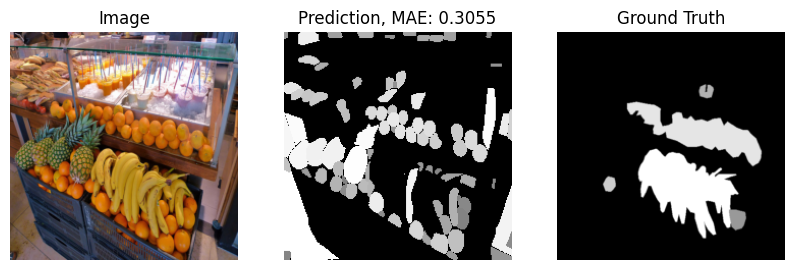

  0%|          | 6/2418 [00:40<4:29:18,  6.70s/it]

Generating saliency map
Generating masks
Ranking segments
Generating grayscale image
[0.5      0.515625 0.53125  0.546875 0.5625   0.578125 0.59375  0.609375
 0.625    0.640625 0.65625  0.671875 0.6875   0.703125 0.71875  0.734375
 0.75     0.765625 0.78125  0.796875 0.8125   0.828125 0.84375  0.859375
 0.875    0.890625 0.90625  0.921875 0.9375   0.953125 0.96875  0.984375
 1.      ]


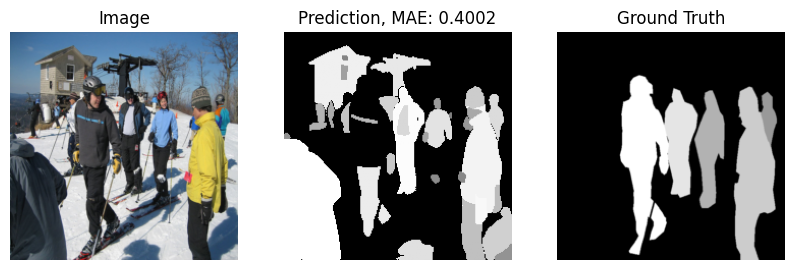

  0%|          | 7/2418 [00:46<4:26:26,  6.63s/it]

Generating saliency map
Generating masks
Ranking segments
Generating grayscale image
[0.5        0.51470588 0.52941176 0.54411765 0.55882353 0.57352941
 0.58823529 0.60294118 0.61764706 0.63235294 0.64705882 0.66176471
 0.67647059 0.69117647 0.70588235 0.72058824 0.73529412 0.75
 0.76470588 0.77941176 0.79411765 0.80882353 0.82352941 0.83823529
 0.85294118 0.86764706 0.88235294 0.89705882 0.91176471 0.92647059
 0.94117647 0.95588235 0.97058824 0.98529412 1.        ]


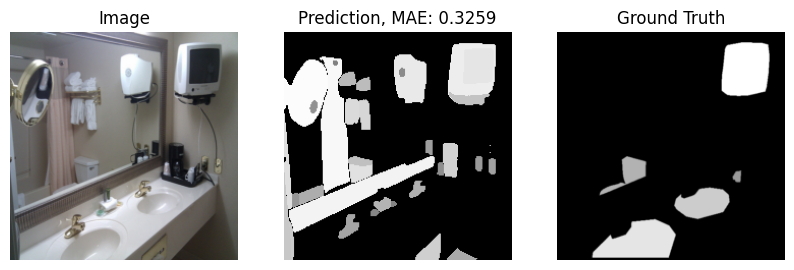

  0%|          | 8/2418 [00:53<4:25:48,  6.62s/it]

Generating saliency map
Generating masks
Ranking segments
Generating grayscale image
[0.5        0.51428571 0.52857143 0.54285714 0.55714286 0.57142857
 0.58571429 0.6        0.61428571 0.62857143 0.64285714 0.65714286
 0.67142857 0.68571429 0.7        0.71428571 0.72857143 0.74285714
 0.75714286 0.77142857 0.78571429 0.8        0.81428571 0.82857143
 0.84285714 0.85714286 0.87142857 0.88571429 0.9        0.91428571
 0.92857143 0.94285714 0.95714286 0.97142857 0.98571429 1.        ]


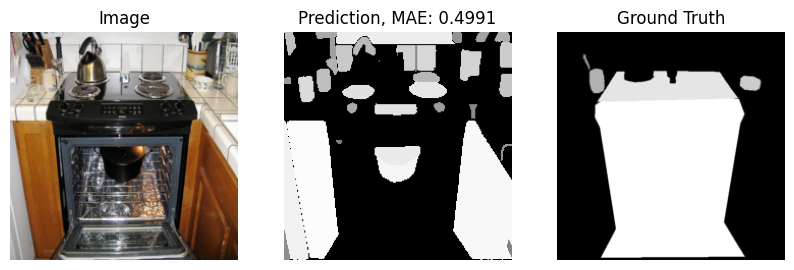

  0%|          | 9/2418 [00:59<4:26:41,  6.64s/it]

Generating saliency map
Generating masks
Ranking segments
Generating grayscale image
[0.5        0.50943396 0.51886792 0.52830189 0.53773585 0.54716981
 0.55660377 0.56603774 0.5754717  0.58490566 0.59433962 0.60377358
 0.61320755 0.62264151 0.63207547 0.64150943 0.6509434  0.66037736
 0.66981132 0.67924528 0.68867925 0.69811321 0.70754717 0.71698113
 0.72641509 0.73584906 0.74528302 0.75471698 0.76415094 0.77358491
 0.78301887 0.79245283 0.80188679 0.81132075 0.82075472 0.83018868
 0.83962264 0.8490566  0.85849057 0.86792453 0.87735849 0.88679245
 0.89622642 0.90566038 0.91509434 0.9245283  0.93396226 0.94339623
 0.95283019 0.96226415 0.97169811 0.98113208 0.99056604 1.        ]


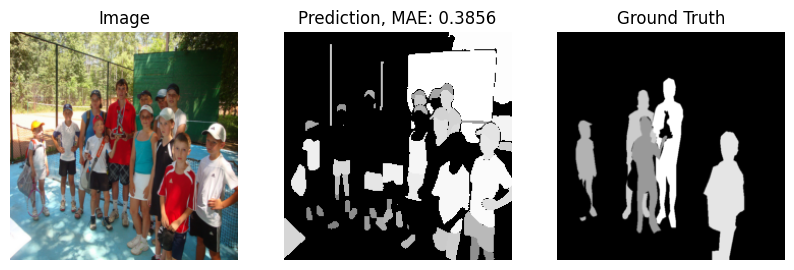

  0%|          | 10/2418 [01:07<4:32:15,  6.78s/it]

Generating saliency map
Generating masks
Ranking segments
Generating grayscale image
[0.5        0.50862069 0.51724138 0.52586207 0.53448276 0.54310345
 0.55172414 0.56034483 0.56896552 0.57758621 0.5862069  0.59482759
 0.60344828 0.61206897 0.62068966 0.62931034 0.63793103 0.64655172
 0.65517241 0.6637931  0.67241379 0.68103448 0.68965517 0.69827586
 0.70689655 0.71551724 0.72413793 0.73275862 0.74137931 0.75
 0.75862069 0.76724138 0.77586207 0.78448276 0.79310345 0.80172414
 0.81034483 0.81896552 0.82758621 0.8362069  0.84482759 0.85344828
 0.86206897 0.87068966 0.87931034 0.88793103 0.89655172 0.90517241
 0.9137931  0.92241379 0.93103448 0.93965517 0.94827586 0.95689655
 0.96551724 0.97413793 0.98275862 0.99137931 1.        ]


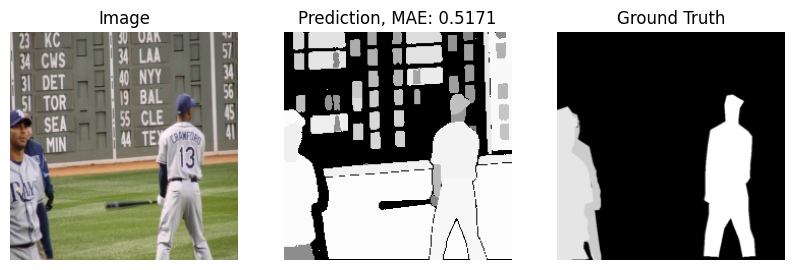

  0%|          | 11/2418 [01:15<4:49:19,  7.21s/it]

Generating saliency map
Generating masks
Ranking segments
Generating grayscale image
[0.5        0.51086957 0.52173913 0.5326087  0.54347826 0.55434783
 0.56521739 0.57608696 0.58695652 0.59782609 0.60869565 0.61956522
 0.63043478 0.64130435 0.65217391 0.66304348 0.67391304 0.68478261
 0.69565217 0.70652174 0.7173913  0.72826087 0.73913043 0.75
 0.76086957 0.77173913 0.7826087  0.79347826 0.80434783 0.81521739
 0.82608696 0.83695652 0.84782609 0.85869565 0.86956522 0.88043478
 0.89130435 0.90217391 0.91304348 0.92391304 0.93478261 0.94565217
 0.95652174 0.9673913  0.97826087 0.98913043 1.        ]


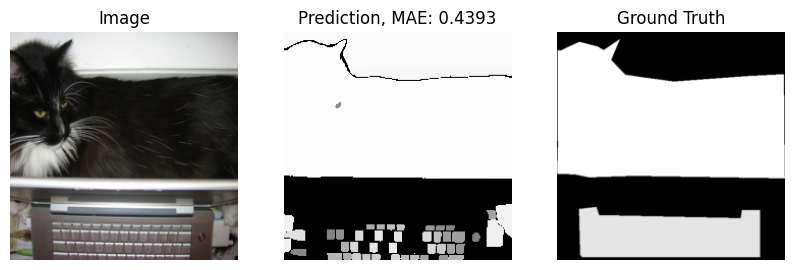

  0%|          | 12/2418 [01:22<4:51:00,  7.26s/it]

Generating saliency map
Generating masks
Ranking segments
Generating grayscale image
[0.5        0.52777778 0.55555556 0.58333333 0.61111111 0.63888889
 0.66666667 0.69444444 0.72222222 0.75       0.77777778 0.80555556
 0.83333333 0.86111111 0.88888889 0.91666667 0.94444444 0.97222222
 1.        ]


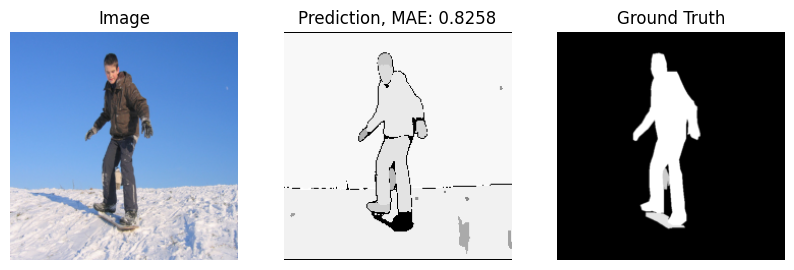

  1%|          | 13/2418 [01:29<4:48:04,  7.19s/it]

Generating saliency map
Generating masks
Ranking segments
Generating grayscale image
[0.5        0.52777778 0.55555556 0.58333333 0.61111111 0.63888889
 0.66666667 0.69444444 0.72222222 0.75       0.77777778 0.80555556
 0.83333333 0.86111111 0.88888889 0.91666667 0.94444444 0.97222222
 1.        ]


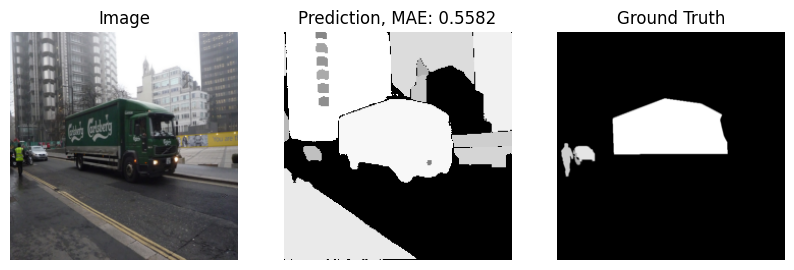

  1%|          | 14/2418 [01:36<4:41:39,  7.03s/it]

Generating saliency map
Generating masks
Ranking segments
Generating grayscale image
[0.5    0.5125 0.525  0.5375 0.55   0.5625 0.575  0.5875 0.6    0.6125
 0.625  0.6375 0.65   0.6625 0.675  0.6875 0.7    0.7125 0.725  0.7375
 0.75   0.7625 0.775  0.7875 0.8    0.8125 0.825  0.8375 0.85   0.8625
 0.875  0.8875 0.9    0.9125 0.925  0.9375 0.95   0.9625 0.975  0.9875
 1.    ]


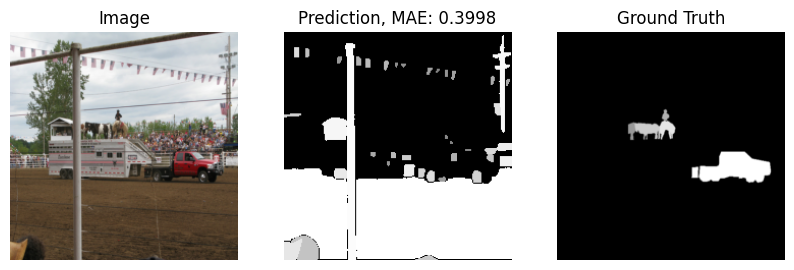

  1%|          | 15/2418 [01:43<4:41:49,  7.04s/it]

Generating saliency map


  1%|          | 15/2418 [01:44<4:38:43,  6.96s/it]


KeyboardInterrupt: 

In [81]:
# Calculate MAE
maes = []

# Calculate SOR
sors = []

for image, mask in tqdm(test_loader):
    image = image.squeeze(0).permute(1, 2, 0).numpy()
    mask = mask.squeeze(0).permute(1, 2, 0).numpy()

    _, _, _, grayscale_image = predictor.predict(image)

    pred = grayscale_image
    gt = mask

    # Calculate MAE
    mae = calculate_mae(pred, gt)
    maes.append(mae)
    

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(pred, cmap='gray')
    plt.title(f'Prediction, MAE: {mae:.4f}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(gt, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.show()

    # Calculate SOR
    # sor = calculate_sor(pred, gt)
    # if sor is not None:
    #     sors.append(sor)

In [49]:
np.mean(maes)

0.28247443

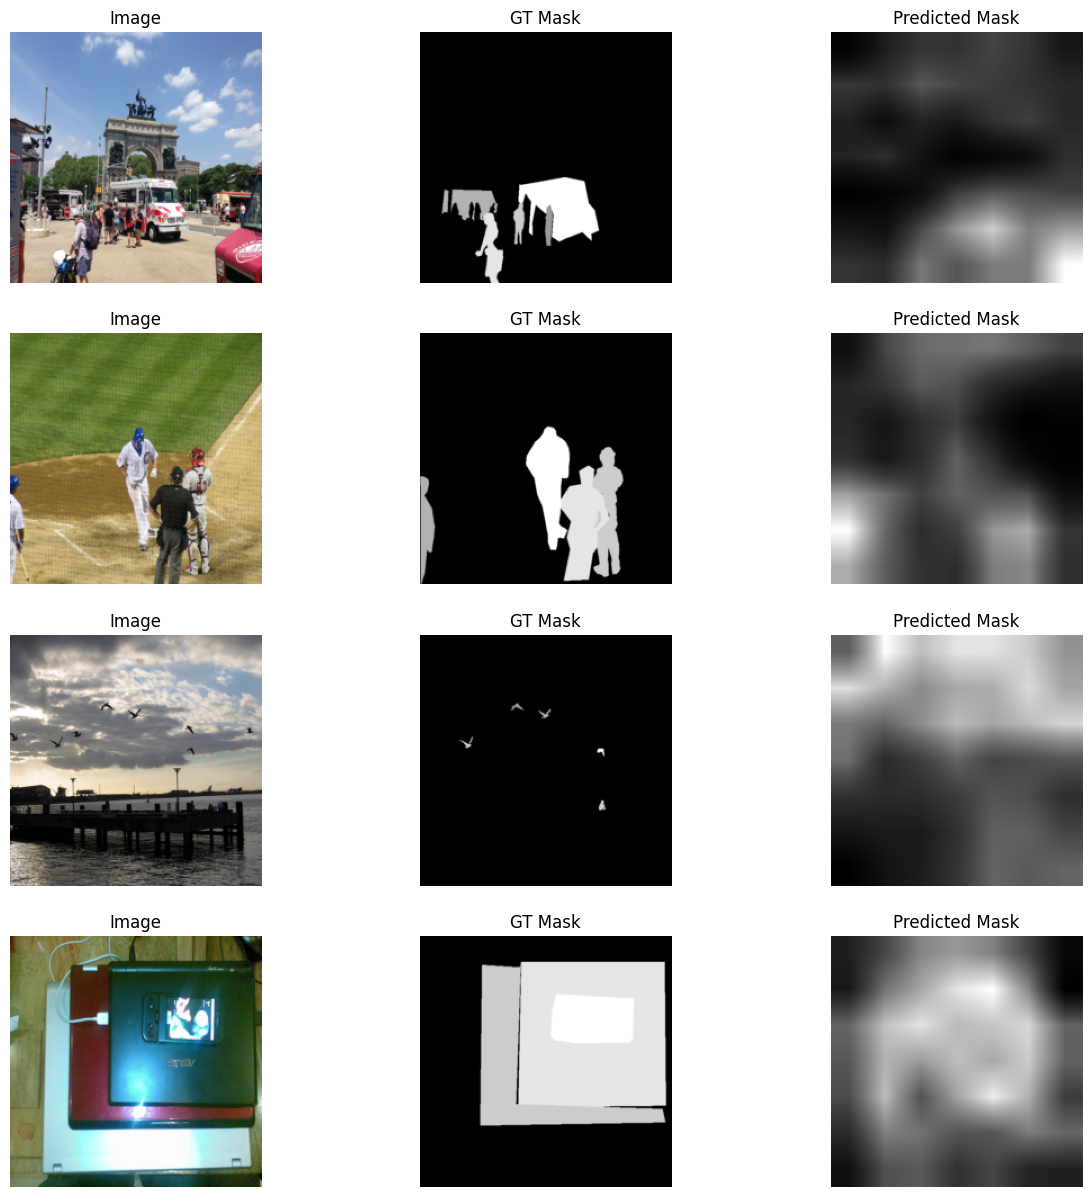

In [33]:
# Qaulitative results. Load some test examples and their GT. Input test into model and display the results
subset_indices = list(range(4))
test_loader = DataLoader(test_dataset, batch_size=1, sampler=torch.utils.data.SubsetRandomSampler(subset_indices))

model.eval()  # Set model to evaluation mode

images = []
gt_masks = []
pred_masks = []

for image, mask in test_loader:
    images.append(image.squeeze().numpy())
    gt_masks.append(mask.squeeze().numpy())

    with torch.no_grad():
        output = model(image.to('cuda' if torch.cuda.is_available() else 'cpu'))
    
    pred_masks.append(output.squeeze().cpu().numpy())

images = np.array(images)
gt_masks = np.array(gt_masks)
pred_masks = np.array(pred_masks)

# Display the images, GT masks, and predicted masks
plt.figure(figsize=(15, 15))
for i in range(4):
    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(images[i].transpose(1, 2, 0))
    plt.axis('off')
    plt.title('Image')

    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(gt_masks[i], cmap='gray')
    plt.axis('off')
    plt.title('GT Mask')

    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(pred_masks[i], cmap='gray')
    plt.axis('off')
    plt.title('Predicted Mask')